<h1>SVM<h1>
    <h5>We solve the tweet classification problem using SVM<h5>

In [2]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import gensim
import re
import dill
import matplotlib.pyplot as plt
from collections import Counter
import string
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
#helper for performance report
def performance(y_true,y_predict,y_proba=[]):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    if (y_proba!=[]):
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_proba)
        area = metrics.auc(false_positive_rate, true_positive_rate)
        plt.figure()
        plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

In [4]:
#dill.load_session('./svm.db')

In [5]:
#load raw tweet dataset
train_df = pd.read_pickle('./train_df.pkl')
test_df = pd.read_pickle('./test_df.pkl')

In [9]:
#load cleaned tweet dataset
train_df_cleaned = pd.read_pickle('./train_df_cleaned.pkl')
test_df_cleaned = pd.read_pickle('./test_df_cleaned.pkl')

<h5>Let us check the performance of ccs score based classification<h5>

Accuracy: 79.4%
[207  43  60 190]
TP: 207
FP: 60
TN: 190
FN: 43
Sensitivity: 82.8%
Specificity: 76.0%
Precision: 77.528%
Recall: 82.8%
f1: 80.077%


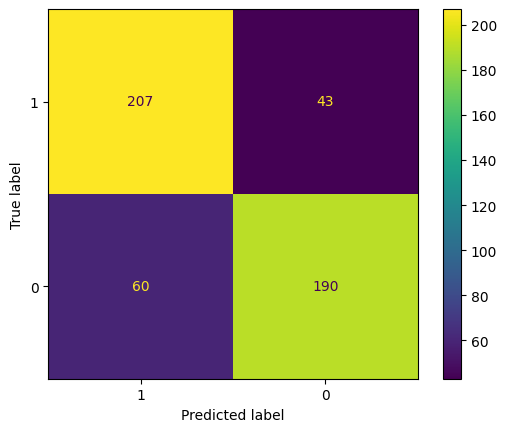

In [42]:
performance(test_df.related_manual,test_df.related_score_based)

<h5>The f1 score of ccs score based classification is not satisfactory evidently.  <h5><br><h5>Let us now test how the SVM model performs in classifying tweets reated to CCS. First, we will check the perofrmance when trained with raw tweets<h5>

In [5]:
#define parameter options for gridsearch
param_grid = {'C':[0.1,1,10,100],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}

In [17]:
#grid initialisation for raw tweets
grid = GridSearchCV(SVC(probability=True),param_grid,refit = True, verbose=2, n_jobs=-1)

In [18]:
#fit the data
%%time
grid.fit(list(train_df.tweet_word2vec_original), train_df.related_manual)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 17.3 s, sys: 1.9 s, total: 19.2 s
Wall time: 1min 40s


GridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [20]:
#hyperparams of the best estimator
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [21]:
#probability prediction
%%time
preds = grid.predict_proba(list(test_df.tweet_word2vec_original))

CPU times: user 63.8 ms, sys: 4.48 ms, total: 68.3 ms
Wall time: 67.8 ms


In [22]:
#convert into binary class prediction
preds_binary = preds[:,1] >= 0.5
preds_binary = preds_binary.astype(np.int64) 

Accuracy: 94.6%
[241   9  18 232]
TP: 241
FP: 18
TN: 232
FN: 9
Sensitivity: 96.4%
Specificity: 92.8%
Precision: 93.05%
Recall: 96.4%
f1: 94.695%


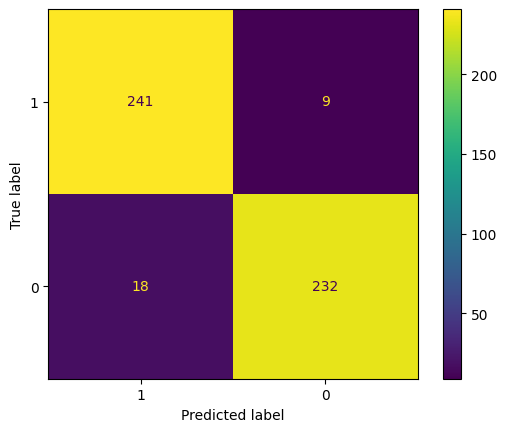

/var/folders/yp/w3wbm1755g3dkb_6mbfzm41r0000gn/T/ipykernel_1200/2394928372.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_proba!=[]):


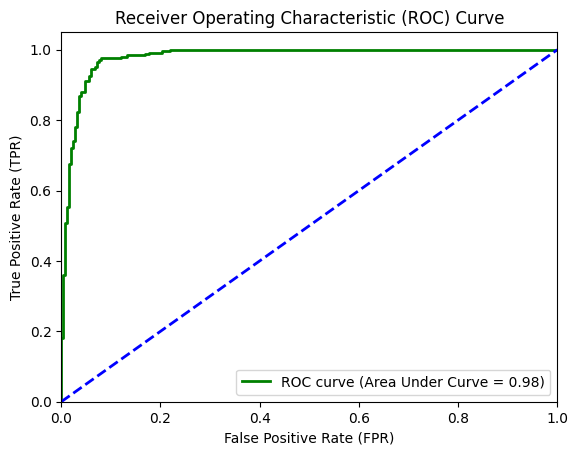

In [40]:
#show performance for raw tweets
performance(test_df.related_manual,preds_binary,preds[:,1])

<h5>Let us now repeat the same procedure with cleaned tweets<h5>

In [6]:
#initalise grid search object for fitting cleaned tweets
grid_2 = GridSearchCV(SVC(probability=True),param_grid,refit = True, verbose=2, n_jobs=-1)

In [10]:
%%time
#fit the data
grid_2.fit(list(train_df_cleaned.tweet_word2vec_preprocessed), train_df_cleaned.related_manual)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 16.8 s, sys: 1.8 s, total: 18.6 s
Wall time: 1min 35s


GridSearchCV(estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [11]:
#best estimator params
grid_2.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [12]:
%%time
#class probability predcition
preds_2 = grid_2.predict_proba(list(test_df_cleaned.tweet_word2vec_preprocessed))

CPU times: user 61.1 ms, sys: 2.11 ms, total: 63.2 ms
Wall time: 62.9 ms


In [13]:
#convert into binary class prediction
preds_binary_2 = preds_2[:,1] >= 0.5
preds_binary_2 = preds_binary_2.astype(np.int64) 

Accuracy: 93.2%
[239  11  23 227]
TP: 239
FP: 23
TN: 227
FN: 11
Sensitivity: 95.6%
Specificity: 90.8%
Precision: 91.221%
Recall: 95.6%
f1: 93.359%


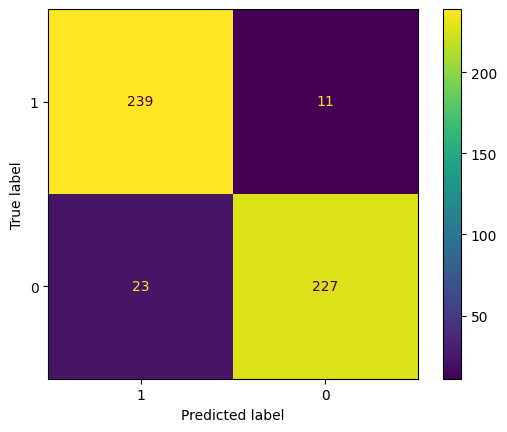

/var/folders/yp/w3wbm1755g3dkb_6mbfzm41r0000gn/T/ipykernel_1089/137007618.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (y_proba!=[]):


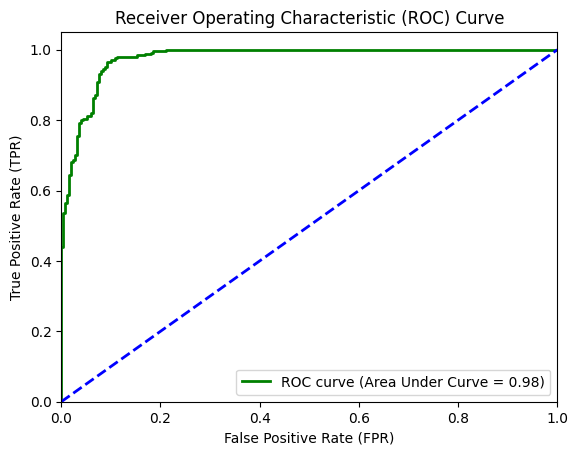

[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   4.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.6s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  15.7s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.8s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=  14.2s
[CV] END .....................C=10, gamma=0.1, kernel=linear; total time=   3.8s
[CV] END ...................C=10, gamma=0.001, kernel=linear; total time=   3.4s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   7.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=  11.3s
[CV] END ..................C=100, gamma=0.001, kernel=linear; total time=   2.8s
[CV] END .................C=100, gamma=0.0001, kernel=linear; total time=   2.7s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   4.8s
[CV] END ...................

In [14]:
#calulate performance
performance(test_df_cleaned.related_manual,preds_binary_2,preds_2[:,1])

<h2>Results<h2>
<h5>Clearly, SVM gives better results with the raw tweets and with following hyperparamteters
    <ol><li>kernel - rbf</li>
        <li>gamma - 0.1</li>
        <li>C - 10</li></ol>
    <h5>

| Model | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|-------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| SVM   | 94.6%    | 241 | 18 | 232 | 9  | 96.4%       | 92.8%       | 93.05%    | 96.4%  | 94.695%  |

<h2>Prediction using SVM<h2>
    <h5>Let us now use the best performing SVM model to classify our entire dataset with 1.2 M tweets.<h5>

In [44]:
#Load the 1.2 M dataset
remaining_df = pd.read_pickle('./remaining_df.pkl')

[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.5s
[CV] END .................C=0.1, gamma=0.0001, kernel=linear; total time=   6.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.5s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   3.7s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   6.7s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   4.3s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   4.4s
[CV] END ......................C=1, gamma=0.0001, kernel=rbf; total time=  15.6s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   3.8s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=  11.2s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   7.3s
[CV] END ...................

In [88]:
%%time
#class probablity prediction
preds_full = grid.predict_proba(list(remaining_df['tweet_word2vec_original']))

CPU times: user 2min 25s, sys: 17.3 s, total: 2min 42s
Wall time: 2min 58s


In [127]:
#convert into binary class prediction and store as a dataframe column
remaining_df['svm_prediction'] = preds_full[:,1] >= 0.5

In [128]:
#filter out tweets that are classified as CCS related by the SVM model
ccs_tweets = remaining_df[remaining_df['svm_prediction']==1]
ccs_tweets

,index,author_id,geo,tweetid,lang,like_count,quote_count,reply_count,retweet_count,tweet_original,...,relevant_manualscore,related_score_based,related_manual,tweet_preprocessed,tweet_tokenized_original,tweet_tokenized_preprocessed,tweet_word2vec_original,tweet_word2vec_preprocessed,context_domain_name,svm_prediction
104,31552,2409610628,62a2a7f86cd9a5b4,1330188388620709890,en,8,0,1,3,@Douglas4Moray @ScotTories What happened to th...,...,None,1,NaN,douglas4moray scottories happened carbon captu...,"[@, Douglas4Moray, @, ScotTories, What, happen...","[douglas4moray, scottories, happened, carbon, ...","[0.02614635732871565, 0.15757921795276078, -0....","[-0.21946153544228186, 0.06381868029182608, -0...",[unknown],True
166,31663,97249109,42d0cf7d49d27c95,1329196712871792642,en,0,0,0,0,"@DehennaDavison Apart from carbon capture, I c...",...,None,1,NaN,dehennadavison apart carbon capture agree,"[@, DehennaDavison, Apart, from, carbon, captu...","[dehennadavison, apart, carbon, capture, agree]","[0.004402765413173116, 0.13632011169997546, -0...","[-0.22108975593000652, 0.06885306537151337, 0....",[unknown],True
845,33057,968885186,31fffbe34de66921,1315694210050396162,en,1,0,1,0,😅😅\r\nHayatu check this out Toh:\r\nIn the cur...,...,None,0,NaN,hayatu check tohin current decarbonisation cli...,"[😅😅, Hayatu, check, this, out, Toh, :, In, the...","[hayatu, check, tohin, current, decarbonisatio...","[0.03419917579316958, 0.033234127128327434, -0...","[-0.16061201762640848, 0.03291385871707462, 0....",[unknown],True
1111,33656,108145016,06168d1feda43857,1310140018971873280,en,2,0,5,0,@angusgowthorpe @Lucy_delaP @BeaumontRobert @j...,...,None,1,NaN,angusgowthorpe lucydelap beaumontrobert jakefi...,"[@, angusgowthorpe, @, Lucy_delaP, @, Beaumont...","[angusgowthorpe, lucydelap, beaumontrobert, ja...","[-0.006971312021102074, 0.13664588316025633, -...","[-0.20380844452107946, 0.11089289101461569, 0....",[unknown],True
1213,33905,892894478,5f9309e9752ea463,1307967161562955779,en,6,0,1,2,Really looking forward to seeing the developme...,...,None,0,NaN,looking forward seeing development delivery de...,"[Really, looking, forward, to, seeing, the, de...","[looking, forward, seeing, development, delive...","[0.008759394832985832, 0.0799023714647232, -0....","[-0.09439443638953178, 0.04362982827360216, 0....",[unknown],True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267200,72992,173754884,7d7bdec12d2549d4,847388991938674688,en,2,0,0,4,Our Nick Phillips enjoying a busy 2 days @_act...,...,None,0,NaN,nick phillips enjoying busy days activenet eve...,"[Our, Nick, Phillips, enjoying, a, busy, 2, da...","[nick, phillips, enjoying, busy, days, activen...","[0.05302703976140995, 0.09509505968736975, -0....","[0.07830443163402379, -0.043366228540738426, -...",[unknown],True
1267448,50903,810845405353279488,06168d1feda43857,1182732313500835841,en,3,0,0,0,"See also @NFUtweets #NetZero 2040 Report, whic...",...,None,1,NaN,nfutweets netzero report highlights precision ...,"[See, also, @, NFUtweets, #, NetZero, 2040, Re...","[nfutweets, netzero, report, highlights, preci...","[0.0643462010462267, 0.13378286461990613, -0.1...","[-0.2782060814535488, 0.1740841518520661, -0.0...",[unknown],True
1267599,42575,376097791,7ee7db2c5d0470e7,1240580289832853506,en,1,0,0,0,@DebbieAnadapta @greenregister Not sure of emb...,...,None,0,NaN,debbieanadapta greenregister sure embodied car...,"[@, DebbieAnadapta, @, greenregister, Not, sur...","[debbieanadapta, greenregister, sure, embodied...","[-0.012834475259296596, 0.05050601592202755, -...","[0.025718508113641292, 0.1124365476280218, -0....",[unknown],True
1267651,73058,3993423317,0af014accd6f6e99,1045965647098916864,en,11,0,0,4,We are a bit further up north at @BGS_Scotland...,...,None,0,NaN,bit north bgsscotland doorsopenday talk ccs re...,"[We, are, a, bit, further, up, north, at, @, B...","[bit, north, bgsscotland, doorsopenday, talk, ...","[0.01492692596249042, 0.142095921290

In [138]:
#get month-year from timestamp
ccs_tweets['month_year'] = ccs_tweets['created_at'].dt.to_period('M').dt.to_timestamp()

/var/folders/yp/w3wbm1755g3dkb_6mbfzm41r0000gn/T/ipykernel_1106/1284719757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccs_tweets['month_year'] = ccs_tweets['created_at'].dt.to_period('M').dt.to_timestamp()


In [163]:
#get date from timestamp
ccs_tweets['date'] = ccs_tweets['created_at'].dt.to_period('D').dt.to_timestamp()

/var/folders/yp/w3wbm1755g3dkb_6mbfzm41r0000gn/T/ipykernel_1106/1566856222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccs_tweets['date'] = ccs_tweets['created_at'].dt.to_period('D').dt.to_timestamp()


In [164]:
ccs_tweets

,index,author_id,geo,tweetid,lang,like_count,quote_count,reply_count,retweet_count,tweet_original,...,related_manual,tweet_preprocessed,tweet_tokenized_original,tweet_tokenized_preprocessed,tweet_word2vec_original,tweet_word2vec_preprocessed,context_domain_name,svm_prediction,month_year,date
104,31552,2409610628,62a2a7f86cd9a5b4,1330188388620709890,en,8,0,1,3,@Douglas4Moray @ScotTories What happened to th...,...,NaN,douglas4moray scottories happened carbon captu...,"[@, Douglas4Moray, @, ScotTories, What, happen...","[douglas4moray, scottories, happened, carbon, ...","[0.02614635732871565, 0.15757921795276078, -0....","[-0.21946153544228186, 0.06381868029182608, -0...",[unknown],True,2020-11-01,2020-11-21
166,31663,97249109,42d0cf7d49d27c95,1329196712871792642,en,0,0,0,0,"@DehennaDavison Apart from carbon capture, I c...",...,NaN,dehennadavison apart carbon capture agree,"[@, DehennaDavison, Apart, from, carbon, captu...","[dehennadavison, apart, carbon, capture, agree]","[0.004402765413173116, 0.13632011169997546, -0...","[-0.22108975593000652, 0.06885306537151337, 0....",[unknown],True,2020-11-01,2020-11-18
845,33057,968885186,31fffbe34de66921,1315694210050396162,en,1,0,1,0,😅😅\r\nHayatu check this out Toh:\r\nIn the cur...,...,NaN,hayatu check tohin current decarbonisation cli...,"[😅😅, Hayatu, check, this, out, Toh, :, In, the...","[hayatu, check, tohin, current, decarbonisatio...","[0.03419917579316958, 0.033234127128327434, -0...","[-0.16061201762640848, 0.03291385871707462, 0....",[unknown],True,2020-10-01,2020-10-12
1111,33656,108145016,06168d1feda43857,1310140018971873280,en,2,0,5,0,@angusgowthorpe @Lucy_delaP @BeaumontRobert @j...,...,NaN,angusgowthorpe lucydelap beaumontrobert jakefi...,"[@, angusgowthorpe, @, Lucy_delaP, @, Beaumont...","[angusgowthorpe, lucydelap, beaumontrobert, ja...","[-0.006971312021102074, 0.13664588316025633, -...","[-0.20380844452107946, 0.11089289101461569, 0....",[unknown],True,2020-09-01,2020-09-27
1213,33905,892894478,5f9309e9752ea463,1307967161562955779,en,6,0,1,2,Really looking forward to seeing the developme...,...,NaN,looking forward seeing development delivery de...,"[Really, looking, forward, to, seeing, the, de...","[looking, forward, seeing, development, delive...","[0.008759394832985832, 0.0799023714647232, -0....","[-0.09439443638953178, 0.04362982827360216, 0....",[unknown],True,2020-09-01,2020-09-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267200,72992,173754884,7d7bdec12d2549d4,847388991938674688,en,2,0,0,4,Our Nick Phillips enjoying a busy 2 days @_act...,...,NaN,nick phillips enjoying busy days activenet eve...,"[Our, Nick, Phillips, enjoying, a, busy, 2, da...","[nick, phillips, enjoying, busy, days, activen...","[0.05302703976140995, 0.09509505968736975, -0....","[0.07830443163402379, -0.043366228540738426, -...",[unknown],True,2017-03-01,2017-03-30
1267448,50903,810845405353279488,06168d1feda43857,1182732313500835841,en,3,0,0,0,"See also @NFUtweets #NetZero 2040 Report, whic...",...,NaN,nfutweets netzero report highlights precision ...,"[See, also, @, NFUtweets, #, NetZero, 2040, Re...","[nfutweets, netzero, report, highlights, preci...","[0.0643462010462267, 0.13378286461990613, -0.1...","[-0.2782060814535488, 0.1740841518520661, -0.0...",[unknown],True,2019-10-01,2019-10-11
1267599,42575,376097791,7ee7db2c5d0470e7,1240580289832853506,en,1,0,0,0,@DebbieAnadapta @greenregister Not sure of emb...,...,NaN,debbieanadapta greenregister sure embodied car...,"[@, DebbieAnadapta, @, greenregister, Not, sur...","[debbieanadapta, greenregister, sure, embodied...","[-0.012834475259296596, 0.05050601592202755, -...","[0.025718508113641292, 0.1124365476280218, -0....",[unknown],True,2020-03-01,2020-03-19
1267651,73058,3993423317,0af014accd6f6e99,1045965647098916864,en,11,0,0,4,We are a bit further up north at @BGS_Scotland...,...,NaN,bit north bgsscotland doorsopenday talk ccs re...,"[We, are, a, bit, further, up, north, at, @, B...","

In [210]:
#Store CCS related tweets as a csv file
ccs_tweets[['tweetid']].to_csv('./related_tweetids_complete.csv')

In [170]:
#group the ccs_tweets table by 'month-year' to get the count of CCS tweets per month_year
timeline_data = ccs_tweets[['tweet_original','month_year']].groupby('month_year',as_index=False).count()

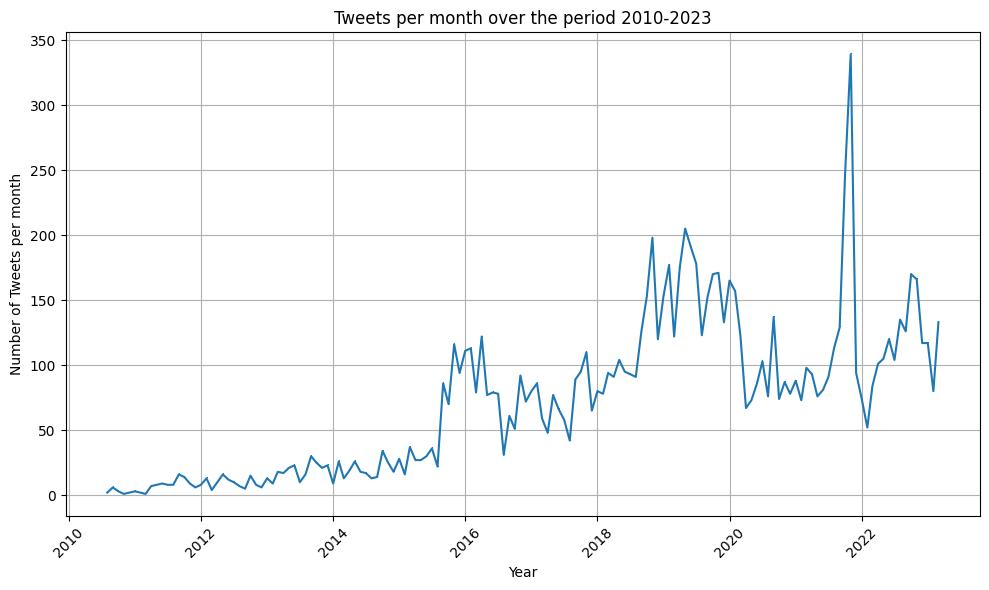

In [132]:
#plot the time series distribution per month_year 
plt.figure(figsize=(10, 6))
plt.plot(timeline_data['month_year'], timeline_data['tweet_original'], marker=',')
plt.xlabel('Year')
plt.ylabel('Number of Tweets per month')
plt.title('Tweets per month over the period 2010-2023')
plt.xticks(rotation=45) 
plt.grid(True)
plt.tight_layout()
plt.show()

From the above time series data we can observe four peaks when the tweet counts increased than normal. These are
<ol><li>Peak A : Sept 2015 - July 2016</li>
    <li>Peak B : Sept 2018 - March 2020</li>
    <li>Peak C : Nov 2021</li>
    <li>Peak D : Oct - Nov 2022</li></ol>
    
For each peak, we create separate datasets, save them as csv files so that it can be retrieved for spatial operations using POstgres and QGIS, and plot a word frequency chat for each of these periods.


<h2>Peak A : Sept 2015 - July 2016<h2>

In [166]:
ccs_tweets_period_1 = ccs_tweets[(ccs_tweets['month_year'] >= '2015-09-01') & (ccs_tweets['month_year'] <='2016-07-01')]

In [190]:
ccs_tweets_period_1[['tweetid']].to_csv('./related_tweetids_period_1.csv')

[('ccs', 316), ('carbon', 297), ('capture', 189), ('energy', 174), ('climatechange', 157), ('emissions', 154), ('amp', 127), ('co2', 125), ('storage', 112), ('uk', 88)]


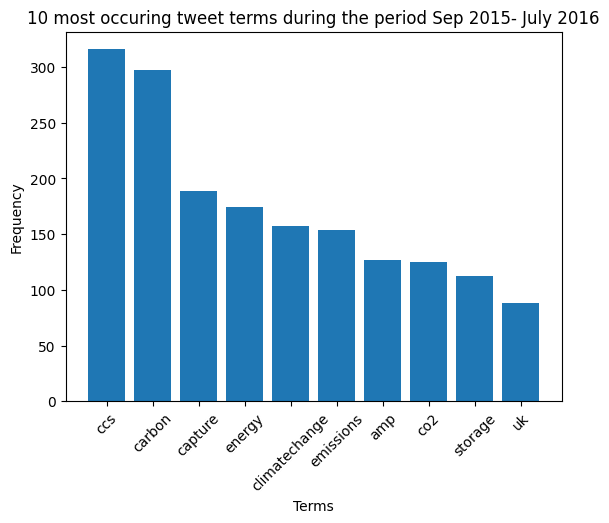

In [206]:
tweets = ccs_tweets_period_1['tweet_preprocessed'].values.tolist()
term_occurences = Counter(" ".join(tweets).split()).most_common(10)
print(term_occurences)
terms = [term for term, _ in term_occurences]
occurences = [occurences for _, occurences in term_occurences]
plt.bar(terms, occurences)
plt.title("10 most occuring tweet terms during the period Sep 2015- July 2016")
plt.ylabel("Frequency")
plt.xlabel("Terms")
plt.xticks(rotation=45)
plt.savefig('./Charts/word_Count_period_1.png', bbox_inches='tight')
plt.show()


<h2>Peak B : Sept 2018 - March 2020<h2>

In [167]:
ccs_tweets_period_2 = ccs_tweets[(ccs_tweets['month_year'] >= '2018-09-01') & (ccs_tweets['month_year'] <='2020-03-01')]

In [191]:
ccs_tweets_period_2[['tweetid']].to_csv('./related_tweetids_period_2.csv')

[('carbon', 3842), ('amp', 2070), ('capture', 1466), ('energy', 1195), ('emissions', 1125), ('decarbonisation', 1050), ('steel', 931), ('storage', 848), ('ccs', 813), ('total', 776)]


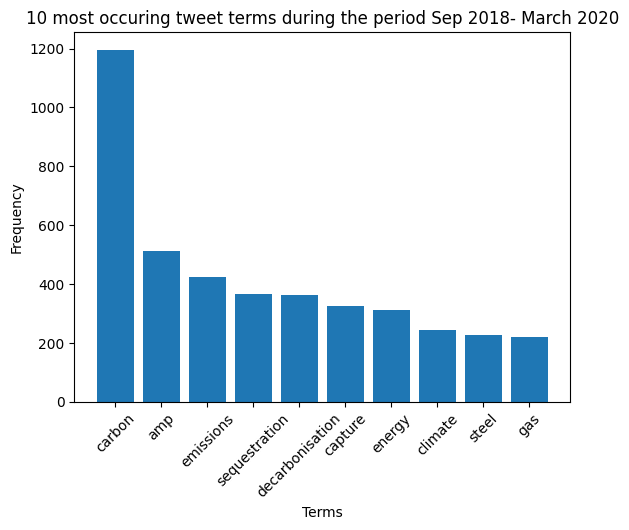

In [207]:
tweets = ccs_tweets_period_2['tweet_preprocessed'].values.tolist()
term_occurences = Counter(" ".join(tweets).split()).most_common(10)
print(word_frequency)
terms = [term for term, _ in term_occurences]
occurences = [occurences for _, occurences in term_occurences]
plt.bar(terms, occurences)
plt.title("10 most occuring tweet terms during the period Sep 2018- March 2020")
plt.ylabel("Frequency")
plt.xlabel("Terms")
plt.xticks(rotation=45)
plt.savefig('./Charts/word_Count_period_2.png', bbox_inches='tight')
plt.show()

<h2>Peak C : Nov 2021<h2>

In [168]:
ccs_tweets_period_3 = ccs_tweets[(ccs_tweets['month_year'] == '2021-11-01')]

In [192]:
ccs_tweets_period_3[['tweetid']].to_csv('./related_tweetids_period_3.csv')

[('carbon', 3842), ('amp', 2070), ('capture', 1466), ('energy', 1195), ('emissions', 1125), ('decarbonisation', 1050), ('steel', 931), ('storage', 848), ('ccs', 813), ('total', 776)]


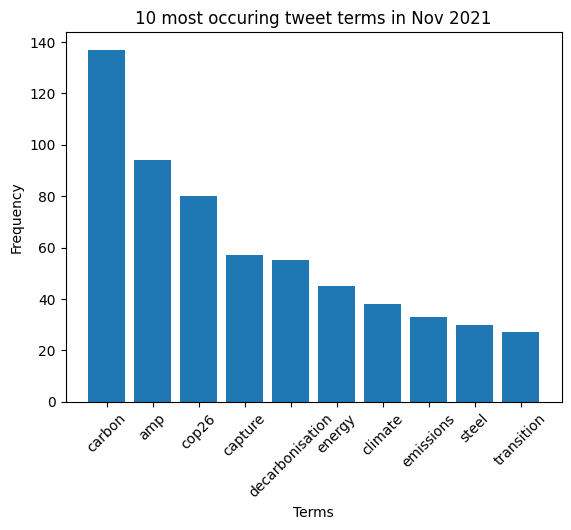

In [208]:
tweets = ccs_tweets_period_3['tweet_preprocessed'].values.tolist()
term_occurences = Counter(" ".join(tweets).split()).most_common(10)
print(word_frequency)
terms = [term for term, _ in term_occurences]
occurences = [occurences for _, occurences in term_occurences]
plt.bar(terms, occurences)
plt.title("10 most occuring tweet terms in Nov 2021")
plt.ylabel("Frequency")
plt.xlabel("Terms")
plt.xticks(rotation=45)
plt.savefig('./Charts/word_Count_period_3.png', bbox_inches='tight')
plt.show()

<h2>Peak D : Oct - Nov 2022<h2>

In [169]:
ccs_tweets_period_4 = ccs_tweets[(ccs_tweets['month_year'] >= '2022-10-01') & (ccs_tweets['month_year'] <='2022-11-01')]

In [193]:
ccs_tweets_period_4[['tweetid']].to_csv('./related_tweetids_period_4.csv')

[('carbon', 3842), ('amp', 2070), ('capture', 1466), ('energy', 1195), ('emissions', 1125), ('decarbonisation', 1050), ('steel', 931), ('storage', 848), ('ccs', 813), ('total', 776)]


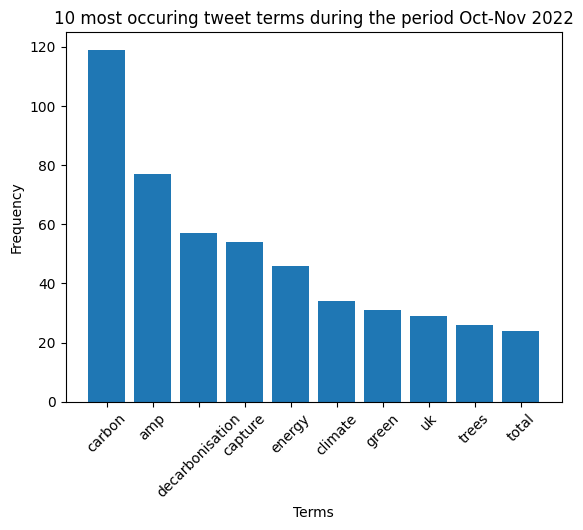

In [209]:
tweets = ccs_tweets_period_4['tweet_preprocessed'].values.tolist()
term_occurences = Counter(" ".join(tweets).split()).most_common(10)
print(word_frequency)
terms = [term for term, _ in term_occurences]
occurences = [occurences for _, occurences in term_occurences]
plt.bar(terms, occurences)
plt.title("10 most occuring tweet terms during the period Oct-Nov 2022")
plt.ylabel("Frequency")
plt.xlabel("Terms")
plt.xticks(rotation=45)
plt.savefig('./Charts/word_Count_period_4.png', bbox_inches='tight')
plt.show()

In [79]:
dill.dump_session('./svm.db')

KeyboardInterrupt: 